In [0]:
from __future__ import division
import numpy as np
import glob
from PIL import Image
import os
from random import *
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.utils import shuffle

import tensorflow as tf
#CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD,Adam, RMSprop

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Sentence writer mapping
#Dict with form and writer mapping

d={}
with open('/content/drive/My Drive/forms_for_parsing.txt') as f:
  for line in f:
    key=line.split(' ')[0]
    writer=line.split(' ')[1]
    d[key]=writer
    

In [0]:
#array for file names and corresponding writer names
tmp=[]
target_list=[]
path_to_files=os.path.join('/content/drive/My Drive/sentences/a01/a01-000u','*')
#path_to_files=os.path.join('/content/drive/My Drive/sentences/a01/a01-00u/a01-000u-s00-00.png','*')
for filename in sorted(glob.glob(path_to_files)):
  tmp.append(filename)
  image_name=filename.split('/')[-1]
  file,ext=os.path.splitext(image_name)
  parts=file.split('-')
  form=parts[0]+'-'+parts[1]
  for key in d:
    if key==form:
      target_list.append(str(d[form]))

img_files=np.asarray(tmp)
img_targets=np.asarray(target_list)

In [6]:
print(img_files)

['/content/drive/My Drive/sentences/a01/a01-000u/a01-000u-s00-00.png'
 '/content/drive/My Drive/sentences/a01/a01-000u/a01-000u-s00-01.png'
 '/content/drive/My Drive/sentences/a01/a01-000u/a01-000u-s00-02.png'
 '/content/drive/My Drive/sentences/a01/a01-000u/a01-000u-s00-03.png'
 '/content/drive/My Drive/sentences/a01/a01-000u/a01-000u-s01-00.png'
 '/content/drive/My Drive/sentences/a01/a01-000u/a01-000u-s01-01.png'
 '/content/drive/My Drive/sentences/a01/a01-000u/a01-000u-s01-02.png'
 '/content/drive/My Drive/sentences/a01/a01-000u/a01-000u-s01-03.png']


In [0]:
from google.colab.patches import cv2_imshow
import cv2
for filename in img_files:
  img=cv2.imread(filename)
  #cv2_imshow(img)
  #img=pyimage.imread(filename)
  #plt.figure(figsize=(10,10))
  #plt.imshow(img,cmap='gray')

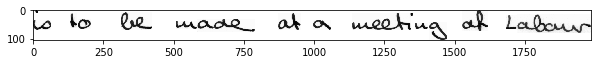

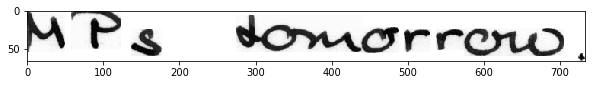

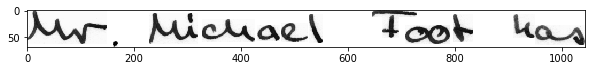

In [8]:
#Visuializa data
for filename in img_files[2:5]:
  img=mpimg.imread(filename)
  plt.figure(figsize=(10,10))
  plt.imshow(img,cmap='gray')

In [9]:
#Label encoder writer names for one hot encoding later
encoder=LabelEncoder()
encoder.fit(img_targets)
encoded_Y=encoder.transform(img_targets)

print(img_targets[:5],encoded_Y[:5])

['000' '000' '000' '000' '000'] [0 0 0 0 0]


In [10]:
#TrainTestSplit
#split into test train and validation in ratio 4:1:1
from sklearn.model_selection import train_test_split

train_files,rem_files,train_targets,rem_targets=train_test_split(
img_files,encoded_Y,train_size=0.66,random_state=52,shuffle=True)

validation_files, test_files, validation_targets, test_targets=train_test_split(
rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(5,) (1,) (2,)
(5,) (1,) (2,)


Clearly, there is quite less data...because I cannot upload it all to my Google Drive.

In [0]:
#Generator function to generate random crops from each sentence
#Generators for randomly cropping 113x113 patches from images

batch_size=16
num_classes=50

#add image augmentations as well
def generate_data(samples, target_files, batch_size=batch_size, factor=0.1):
  num_samples=len(samples)
  while True:
    for offset in range(0,num_samples,batch_size):
      batch_samples=samples[offset:offset+batch_size]
      batch_targets=target_files[offset:offset+batch_size]
      
      images=[]
      targets=[]
      for i in range(len(batch_samples)):
        batch_sample=batch_samples[i]
        batch_target=batch_targets[i]
        im=Image.open(batch_sample)
        cur_width=im.size[0]
        cur_height=im.size[1]
        
        height_fac=113/cur_height
        
        new_width=int(cur_width*height_fac)
        size=new_width,113
        
        imresize=im.resize((size),Image.ANTIALIAS) #Maintain aspect ratio
        now_width=imresize.size[0]
        now_height=imresize.size[1]
        
        avail_x_points=list(range(0,now_width-113))
        
        #Pick random x
        pick_num=int(len(avail_x_points)*factor)
        
        random_startx=sample(avail_x_points, pick_num)
        
        for start in random_startx:
          imcrop=imresize.crop((start,0,start+113,113))
          images.append(np.asarray(imcrop))
          targets.append(batch_target)
          
      X_train=np.array(images)
      y_train=np.array(targets)
      
      #reshape
      X_train=X_train.reshape(X_train.shape[0],113,113,1)
      #Convert to float and normalize
      X_train=X_train.astype('float32')
      X_train/=255
      
      #one hot encode y
      y_train=to_categorical(y_train,num_classes)
      
      yield shuffle(X_train,y_train)

In [0]:
# Generate data for training and validation
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

In [21]:
#NN in Keras

#Resize img to 56x56
def resize_image(image):
  return tf.image.resize_images(image,[56,56])

row,col,ch=113,113,1

model=Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(row,col,ch)))

#Resize data with neural network
model.add(Lambda(resize_image))

#CNN
model.add(Convolution2D(filters=32,kernel_size=(5,5),strides=(2,2),padding='same',name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='pool1'))

model.add(Convolution2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',name='conv2')) #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='ppol2'))

model.add(Convolution2D(filters=128, kernel_size=(3,3),strides=(1,1),padding='same',name='conv3')) #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='pool3'))

model.add(Flatten())
model.add(Dropout(0.5)) #reduce overfitting

model.add(Dense(512,name='dense1')) #1024
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256,name='dense2'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, name='output'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
print(model.summary())



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_5 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 14, 14, 64)     

In [22]:
#Train model

nb_epoch=8 #10

samples_per_epoch=3628
nb_val_samples=842

#save checkpoints
from keras.callbacks import ModelCheckpoint
filepath="checkpoint2/check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

#Model fit generator
history_object = model.fit_generator(train_generator, samples_per_epoch= samples_per_epoch,
                                     validation_data=validation_generator,
                                     nb_val_samples=nb_val_samples, nb_epoch=nb_epoch, verbose=1, callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=3628, epochs=8, validation_steps=842)`
  app.launch_new_instance()


Epoch 1/8
 268/3628 [=>............................] - ETA: 5:00:48 - loss: 0.0457 - acc: 0.9941

KeyboardInterrupt: ignored

**MODEL IS OVERFITTING!**